# Basics of RDDs

### Getting started with Apache Spark

**Apache Spark** is a fast and general engine for large-scale data processing. It has been reported that Spark is **100x faster** than Hadoop MapReduce in memory and **10x faster** on disk. Apache Spark is designed to write applications quickly in Java, Scala or Python. It aims to provide a big data processing framework that can be used for streaming data manipulation (Spark streaming), machine learing and batch processing (Hadoop integration). Spark introduces an **abstract common data format** used to for efficient data sharing across parallel computation - **RDD (Resilient Distributed Datasets)**.

Let's get started.


# Spark Configuration
To run a Spark application on the local/cluster, a few configurations and parameters need to be set, for this, **`SparkConf`** provides configurations to run a Spark application. The following code block will set the main parameters we need for the exercise.

In [ ]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Introduction to Apache Spark"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# 1. SparkContext and SparkSession
Apache Spark community released a powerful Python package, **`pyspark`**. Using **`pyspark`**, we can  initialise Spark, create RDD  from the data, sort, filter and sample the data. Especially, we will use and import **`SparkContext`** from **`pyspark`**, which is the main entry point for Spark Core functionality. The **`SparkSession`** object provides methods used to create DataFrames from various input sources.  

Spark applications run as independent sets of processes on a cluster, which is specified by the **`SparkContext`** object. **`SparkContext`** can connect to several types of cluster managers (local (standalone), Mesos or YARN), which allocate resources across applications. Once connected, Spark acquires executors on nodes in the cluster, which are processes that run computations and store data for your application. Next, it sends your application code (passed to `SparkContext`) to the executors. Finally, **`SparkContext`** sends tasks to the executors to run.

However, only one SparkContext instance should be active per JVM. There are two ways to create a SparkContext as shown in the next block of code. Since we will only use RDDs for this tutorial, we will use the second method which creates the SparkContext directly

In [ ]:
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# # Method 1: Using SparkSession
# spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
# sc = spark.sparkContext
# sc.setLogLevel('ERROR')

# Method 2: Getting or instantiating a SparkContext
sc = SparkContext.getOrCreate(spark_conf)
sc.setLogLevel('ERROR')

# 2. RDD object

Resilient Distributed Dataset (RDD) is Spark’s core abstraction for working with data. It is simply an immutable distributed collection of objects.  Spark automatically distributes the data contained in RDDs across the cluster and parallelizes the operations performed on them. Each RDD is split into multiple partitions, which may be computed on different nodes of the cluster. RDDs can contain any type of Python, Java, or Scala objects, including user defined classes. In Spark, all work is expressed as either creating new RDDs, transforming existing RDDs, or calling operations on RDDs to compute a result.


The class `pyspark.SparkContext` creates a client which connects to a Spark cluster. This client can be used to create an RDD object. There are two methods from this class for directly creating RDD objects:
* `parallelize()`
* `textFile()`

## `parallelize()`

`parallelize()` distribute a local **python collection** to form an RDD. Common built-in python collections include `list`, `tuple` or `set`.

Examples: loading data using `parallelize()` method

In [ ]:
## FROM A LIST

# By default the number of partitions will be the number of threads
data_list = [i for i in range(10)]
rdd = sc.parallelize(data_list)

# You can verify the number of partitions of the data 
print('Default partitions: ',rdd.getNumPartitions())

# the function parallelize can have a second argument to indicate manually how many
# partitions for the data
rdd = sc.parallelize(data_list,5)

# Verify the new number of partitions of the data 
print('Manual partitions: ',rdd.getNumPartitions())

# Show the data by performing the action *collect*
rdd.collect()

In [ ]:
## FROM A TUPLE
list_t = [('cat', 'dog', 'fish'), ('orange', 'apple')]
rdd = sc.parallelize(list_t)
rdd.collect()

In [ ]:
## FROM A SET
s = {'cat', 'dog', 'fish', 'cat', 'dog', 'dog'}
rdd = sc.parallelize(s)
rdd.collect()

## `textFile()`

The `textFile()` function reads a text file and returns it as an **RDD of strings**. Usually, you will need to apply some **map** functions to transform each elements of the RDD to some data structure/type that is suitable for data analysis.

**When using `textFile()`, each line of the text file becomes an element in the resulting RDD.**

Examples: loading data from external dataset

In [ ]:
# read a txt file, you can use the same function for a csv file
rdd = sc.textFile('twitter.txt')
print('Default partitions: ',rdd.getNumPartitions())

# the function textFile can have a second argument to indicate manually the minimum
# number of partitions for the data
rdd = sc.textFile('twitter.txt', 5)

# Verify the new number of partitions of the data 
print('Manual partitions: ',rdd.getNumPartitions())

# rdd.take(5)

# 3. RDD Operations
RDDs support two types of operations: 
- transformations and 
- actions.

*Transformations* are operations on RDDs that return a new RDD, such as `map()` and `filter()`. 

*Actions* are operations that return a result to the driver program or write it to storage, and kick off a computation, such as `count()` and `first()`.

Spark treats transformations and actions very differently, so understanding which type of operation you are performing will be important. If you are ever confused whether a given function is a transformation or an action, you can look at its return type: transformations return RDDs, whereas actions return some other data type. 


## Element-wise transformations

These functions are probably the most commonly used functions when dealing with an RDD object.

* `map()`
* `mapValues()`
* `flatMap()`
* `flatMapValues()`

### 3.1 `map`

The `map()` method applies a function to each elements of the RDD. Each element has to be a valid input to the function. The returned RDD has the function outputs as its new elements.

Elements in the RDD object `map_exp_rdd` below are rows of the [mtcars](mtcars.csv) in string format. We are going to apply the `map()` function multiple times to convert each string elements as a list elements. Each list element has two values: the first value will be the auto model in string format; the second value will be a list of numeric values.

In [ ]:
# create an example RDD
map_exp_rdd = sc.textFile('mtcars.csv')
print('Default partitions: ',map_exp_rdd.getNumPartitions())
# show 4 records with the Spark *action* take
map_exp_rdd.take(4)

In [ ]:
# # split auto model from other feature values
# map_exp_rdd_1 = map_exp_rdd.map(lambda x: x.split(',')).map(lambda x: (x[0], x[1:]))
# map_exp_rdd_1.take(4)

In [ ]:
# remove the header row
header = map_exp_rdd.first()
# the filter method apply a function to each elemnts. The function output is a boolean value (TRUE or FALSE)
# elements that have output TRUE will be kept.
map_exp_rdd_1 = map_exp_rdd.filter(lambda x: x != header)
# show 4 records with the Spark *action* take
map_exp_rdd_1.take(4)

In [ ]:
# Implement function with logic to be applied to the RDDs
def parseRecord(line):
    # Split line separated by comma
    array_line = line.split(',')
    # Return a tuple with the car model as first element and the remaining as the second element
    return (array_line[0], array_line[1:])

map_exp_rdd_2 = map_exp_rdd_1.map(parseRecord)
map_exp_rdd_2.take(4)

In [ ]:
# convert string values to numeric values
map_exp_rdd_3 = map_exp_rdd_2.map(lambda x: (x[0], list(map(float, x[1]))))
map_exp_rdd_3.take(4)

### 3.2 `mapValues`

The `mapValues` function requires that each element in the RDD has a **key/value** pair structure, for example, a tuple of 2 items, or a list of 2 items. The `mapValues` function applies a function to each of the element values. The element key will remain unchanged.

We can apply the `mapValues` function to the RDD object `mapValues_exp_rdd` below.

In [ ]:
mapValues_exp_rdd = map_exp_rdd_3
mapValues_exp_rdd.take(4)

In [ ]:
# Uncomment the command below to install numpy
#!pip install numpy
import numpy as np
mapValues_exp_rdd_1 = mapValues_exp_rdd.mapValues(lambda x: np.mean(x))
mapValues_exp_rdd_1.take(4)

When using mapValues(), the x in the above lambda function refers to the element value, not including the element key.

### 3.3 `flatMap`

This function first applies a function to each elements of an RDD and then flatten the results. We can simply use this function to flatten elements of an RDD without extra operation on each elements.


In [ ]:
x = [('a', 'b', 'c'), ('a', 'a'), ('c', 'c', 'c', 'd')]
flatMap_exp_rdd = sc.parallelize(x)
flatMap_exp_rdd.collect()

In [ ]:
flatMap_exp_rdd_1 = flatMap_exp_rdd.flatMap(lambda x: x)
flatMap_exp_rdd_1.collect()

### 3.4 `flatMapValues`

The `flatMapValues` function requires that each element in the RDD has a **key/value** pair structure. It applies a function to each **element value** of the RDD object and then flatten the results.

For example, my raw data looks like below. But I would like to transform the data so that it has three columns: the first column is the **sample id**; the second the column is the three **types (A,B or C)**; the third column is the **values**.

| sample id |  A |  B |  C |
|:---------:|:--:|:--:|:--:|
|     1     | 23 | 18 | 32 |
|     2     | 18 | 29 | 31 |
|     3     | 34 | 21 | 18 |

In [ ]:
# example data
my_data = [
    [1, (23, 28, 32)],
    [2, (18, 29, 31)],
    [3, (34, 21, 18)]
]
flatMapValues_exp_rdd = sc.parallelize(my_data)
flatMapValues_exp_rdd.collect()

In [ ]:
# merge A,B,and C columns into on column and add the type column
flatMapValues_exp_rdd_1 = flatMapValues_exp_rdd.flatMapValues(lambda x: list(zip(list('ABC'), x)))
flatMapValues_exp_rdd_1.collect()

In [ ]:
# unpack the element values
flatMapValues_exp_rdd_2 = flatMapValues_exp_rdd_1.map(lambda x: [x[0]] + list(x[1]) )
flatMapValues_exp_rdd_2.collect()

### 3.5 Transform data to a tuple RDD

Key Value pairs (tuples) are a common data type required in many operations in Spark. They are commonly used to perform aggregations. Spark provides special operations on RDDs containing key value pairs, These RDDs are called pair RDDs. They expose operations that allow you to act on each key in parallel or regroup data across the network. For example, pair RDDs have a reduceByKey() method that can aggregate data separately for each key, and a join() method that can merge two RDDs together by grouping elements with the same key.

We will use the data from `iris.csv` and convert it into a key value pair using `map()` function.

In [ ]:
iris_rdd = sc.textFile('iris.csv', use_unicode=True)
iris_rdd.take(2)

In [ ]:
iris_rdd_2 = iris_rdd.map(lambda x: x.split(',')).\
    filter(lambda x: x[0] != 'sepal_length').\
    map(lambda x: (x[-1], [*map(float, x[:-1])]))
iris_rdd_2.take(5)

## Accumulator

Accumulators provides a simple syntax for aggregating values from worker nodes back to the driver program.
They are only “added” to through an associative and commutative operation and can therefore be efficiently supported in parallel. 

In [ ]:
twitter_rdd = sc.textFile('twitter.txt', 3)
blank_lines = 0 # global variable

def extract_blank_lines(line):
    if line == "":
        blank_lines += 1
    return line.split(" ")
        
word_rdds = twitter_rdd.flatMap(extract_blank_lines)
word_rdds.collect()

print("Blank lines: %d" %blank_lines)

### Why does the code above generate error? 
Now, Try the code below.

In [ ]:
twitter_rdd = sc.textFile('twitter.txt', 3)
blank_lines = sc.accumulator(0) # Create Accumulator[int] intitialized to 0

def extract_blank_lines(line):
    global blank_lines # make the global variable accessible
    lll = {'a':1}
    if line == "":
        print(type(line))
        blank_lines += 1
    return line.split(" ")
        
word_rdds = twitter_rdd.flatMap(extract_blank_lines)
word_rdds.collect()

print("Blank lines: %d" %blank_lines.value)

In [ ]:
bad_words = {'crap', 'rascals', 'fuck'}
bad_words_count = sc.accumulator(0) # Create Accumulator[int] intitialized to 0

broadcast_bad_words = sc.broadcast(bad_words)

twitter_rdd = sc.textFile('twitter.txt', 3)
twitter_rdd.collect()

def check_bad_words(line):
    global bad_words_count # make the global variable accessible
    words = line.split(" ")
    for word in words:
        if word in broadcast_bad_words.value: # using the broadcast variable in the function that runds on the cluster
            bad_words_count += 1
            
filtered_tweets = twitter_rdd.filter(check_bad_words)
filtered_tweets.collect()

print("Bad words: %d" %bad_words_count.value)

### For more transformations and actions please refer to the Spark guide
https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations

# 4. Visualisation of parallelism execution in Spark

To reset and test the following application, we will stop the previous SparkContext and initialise a new one with all the threads possible

In [ ]:
# Stop the SparkContext
sc.stop()

# Start new SparkContext
sc = SparkContext.getOrCreate(spark_conf)

In [ ]:
# We will copy the previous code that reads the file mtcars.csv
map_exp_rdd = sc.textFile('mtcars.csv',4)

header = map_exp_rdd.first()
map_exp_rdd_1 = map_exp_rdd.filter(lambda x: x != header)

# parseRecord is already implemented
map_exp_rdd_2 = map_exp_rdd_1.map(parseRecord)
map_exp_rdd_3 = map_exp_rdd_2.map(lambda x: (x[0], list(map(float, x[1]))))

# Verify the number of partitions
print('Default partitions: ',map_exp_rdd.getNumPartitions())

Now open the browser to <b>http://[your_vm_ip_address]:4040</b> which is the Spark UI page and verify that there is no information of any job started as shown in the image below.
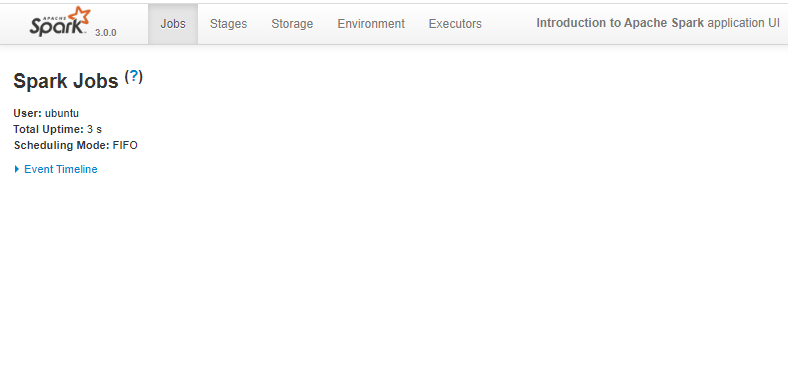

This is because so far, for this new SparkContext, we have only done transformations to the RDDS and haven't performed any *actions*. In the next code block the *action* collect()

In [ ]:
# Perform collect() action to execute the job
map_exp_rdd_3.collect()

* Now that you have performed a collect() *action*, go back to the Spark UI page and refresh to see as the image below.
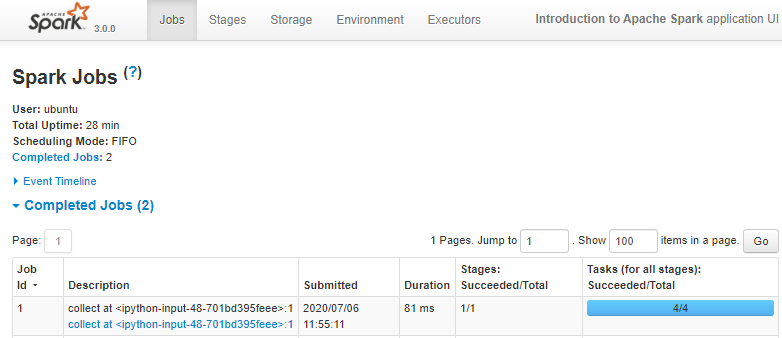

* Click the hyperlink that states [collect at ...] and once again until you reach the page of the stages from the job. There you will find the details of how the job was executed as below.
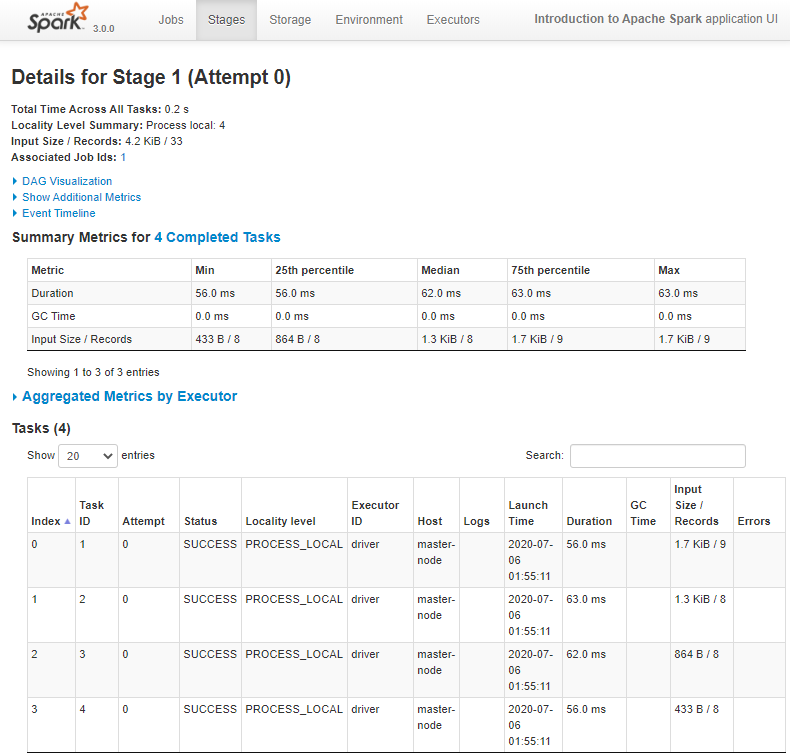

* Click the Event Timeline so you can see the parallelism of the process as shown below. For this case, there were 4 partitions that were processed in 4 separated threads on this machine. This may vary for you depending on how many CPUs you have in your (virtual) machine.
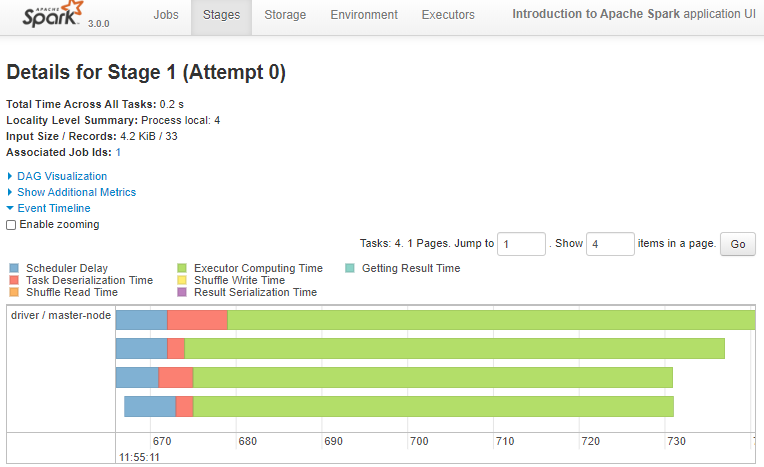

## Exercise: Implement word count using Apache Spark.

In [ ]:
# step 1: Read the text file twitter.txt


# step 2: Use a transformation to break the lines to individual words


# step 3: Use a transformation to convert word to a key/value pair of (word, 1)


# step 4: Use a transformation to reduce the value based on the word


# step 5: Collect and display the results of the count

# step 6: Verify in the Spark UI the parallelism done for this implementation

**Congratulations on finishing this activity!**